# Compute emission pattern of an NV center few nanometers beneath a diamond surface, based on Lethiec et al. (PRX 4, 021037 (2014))
# Supplemenatary Information for "Weinbrenner, P.; Lopez Benet, A.; Gözel, İ.; Reinhard F. "Harnessing the Diamond-Air Interface as an Efficient Photon Antenna for Solid-State Emitters"


In [ ]:
# install perceptually uniform colormaps
!pip install cmcrameri
# import libraries
import numpy
import matplotlib.pyplot as plt
import numpy as np
import cmcrameri.cm as cmc
import scipy.integrate
plt.rcParams['image.cmap'] = 'cmc.batlow'

## Definitions
Definition of angular variables and general parameters

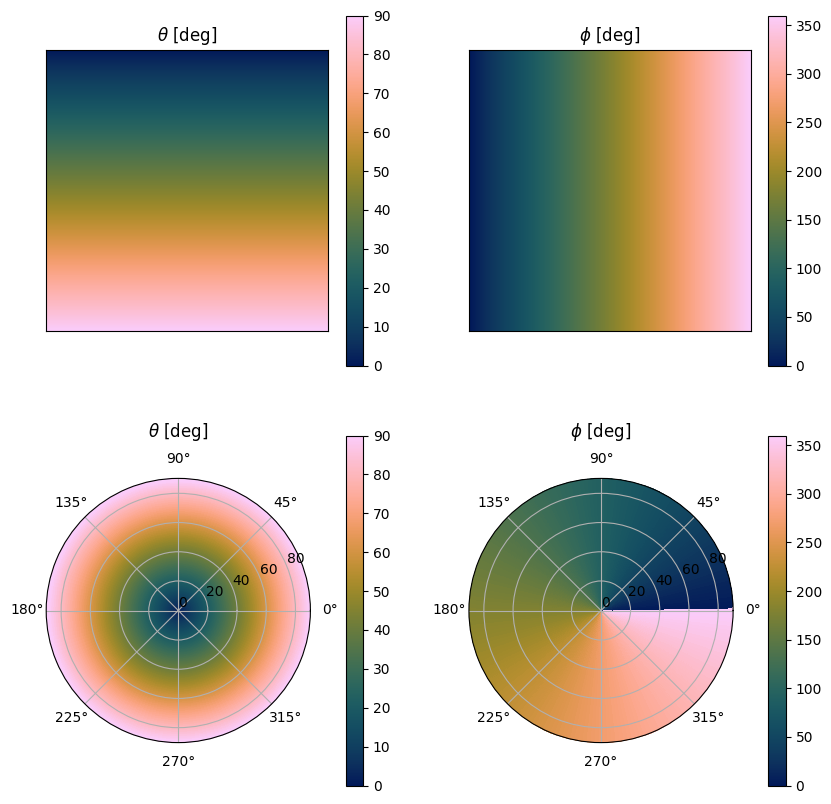

In [ ]:
# simulation space. Emission is parametrized by the direction of emission,
# expressed in polar coordinates theta, phi, covering the entire lower halfspace
# (emission into the diamond)
N = 201 # number of points on grid
phis, dphi = np.linspace(0,2*np.pi, N, retstep=True) # azimuthal coordinates in rad
thetas, dtheta = np.linspace(0, np.pi/2, N, retstep=True) # polar coordinate in rad
phiphi, thetatheta = np.meshgrid(phis, thetas)

lambda_0 = 700e-9 # NV emission wavelength in free space in meters
n_diamond = 2.41 # refractive index of diamond
n_oil = 1.51 # refractive index of standard immersion oil
n_air = 1.0 # refractive index of air

# plot angles for reference
plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.imshow(np.rad2deg(thetatheta))
plt.colorbar()
plt.yticks([])
plt.xticks([])
plt.title(r"$\theta$ [deg]")
plt.subplot(222)
plt.imshow(np.rad2deg(phiphi))
cbar = plt.colorbar()
plt.yticks([])
plt.xticks([])
plt.title(r"$\phi$ [deg]")
plt.subplot(223, projection='polar')
plt.pcolormesh(phis,np.rad2deg(thetas),np.rad2deg(thetatheta),edgecolors='face')
plt.title(r"$\theta$ [deg]", pad=30)
plt.colorbar(pad=0.1)
plt.subplot(224, projection='polar')
plt.pcolormesh(phis,np.rad2deg(thetas),np.rad2deg(phiphi),edgecolors='face')
plt.title(r"$\phi$ [deg]", pad=30)
plt.colorbar(pad=0.1)

## Compute free-space dipole emission pattern (eqs 6-9 in Lethiec et al.).
This dipole pattern will later be mirrored, multiplied by Fresnel coefficients and superimposed onto itself to model emission at a planar dielectric interface.

Text(0.5, 1.0, 'Radiated intensity')

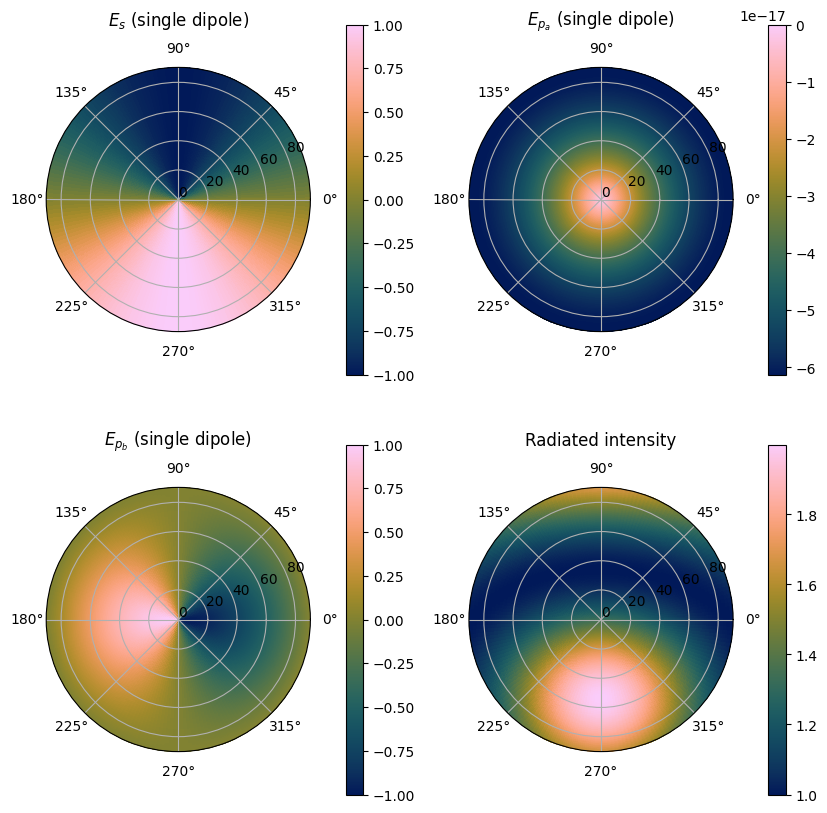

In [ ]:
# Chooser which dipole configuration to use for the simulation:
#1: Single dipole parallel to interface
#theta_dipole = np.array([np.pi/2])
#phi_dipole = np.array([0])

#2: Dipole orientations for <100> diamond
theta_nv = np.pi/2 - np.arctan(1/np.sqrt(2))
phi_nv = np.pi/2
theta_dipole = np.array([np.pi/2-theta_nv, np.pi/2])
phi_dipole = np.array([phi_nv, phi_nv + np.pi/2])

#3: Dipole orientations for <111> diamond
#theta_nv = 0
#phi_nv = 0
#theta_dipole = np.array([np.pi/2-theta_nv, np.pi/2])
#phi_dipole = np.array([phi_nv, phi_nv + np.pi/2])

n_dipoles = theta_dipole.shape[0] # number of dipoles

# Define functions to calculate the electric field components for a given
# dipole orientation
def calc_E_s(theta, phi, theta_dipole, phi_dipole):
    return np.sin(theta_dipole) * np.sin(phi-phi_dipole)


def calc_E_p_a(theta, phi, theta_dipole, phi_dipole):
    return -np.cos(theta_dipole) * np.sin(theta)


def calc_E_p_b(theta, phi, theta_dipole, phi_dipole):
    return np.sin(theta_dipole) * np.cos(theta) * np.cos(phi_dipole-phi)

total_intensity_free = np.zeros((N, N)) # array where the intensity will be stored

# Iterate over all dipoles and add up the emission incoherently, i.e.
# sum the intensity for all dipoles and not the electric field amplitude
for i in np.arange(n_dipoles):
    E_s = calc_E_s(thetatheta, phiphi, theta_dipole[i], phi_dipole[i])
    E_p_a = calc_E_p_a(thetatheta, phiphi, theta_dipole[i], phi_dipole[i])
    E_p_b = calc_E_p_b(thetatheta, phiphi, theta_dipole[i], phi_dipole[i])

    total_intensity_free += np.absolute(E_s)**2 + np.absolute(E_p_b + E_p_a)**2

# integrate the emitted intensity of a dipole in one half space
phi_integrated_intensity_free = scipy.integrate.trapezoid(total_intensity_free * np.sin(thetatheta), phis, axis=1)
integrated_intensity_free = scipy.integrate.trapezoid(phi_integrated_intensity_free, thetas)

# Plot the electric field components of one dipole
plt.figure(figsize=(10, 10))
plt.subplot(221, projection='polar')
plt.pcolormesh(phis, np.rad2deg(thetas), E_s, edgecolors='face')
plt.colorbar(pad=0.1)
plt.title(r"$E_s$ (single dipole)", pad=30)

plt.subplot(222, projection='polar')
plt.pcolormesh(phis, np.rad2deg(thetas), E_p_a, edgecolors='face')
plt.colorbar(pad=0.1)
plt.title(r"$E_{p_a}$ (single dipole)", pad=30)

plt.subplot(223, projection='polar')
plt.pcolormesh(phis, np.rad2deg(thetas), E_p_b, edgecolors='face')
plt.colorbar(pad=0.1)
plt.title(r"$E_{p_b}$ (single dipole)", pad=30)

# Plot the intensity for all dipoles
plt.subplot(224, projection='polar')
plt.pcolormesh(phis, np.rad2deg(thetas), total_intensity_free, edgecolors='face')
plt.colorbar(pad=0.1)
plt.title("Radiated intensity", pad=30)


## Compute Fresnel reflection coefficient for complex amplitudes.

This calculation is based on the standard equations [1, 2] for the Fresnel coefficients.
Firstly we define $n = \frac{n_{in}}{n_{out}}$, where $n_{in}$ is the refractive index of the medium, that the light is emerging from and $n_{out}$ the refractive index of the madium that the light is transmitted into.
The Fresnel coefficients for the amplitude of the electric fields are then given by:
$$
r_s = \frac{n \cos \theta_{in} - \cos \theta_{out}}{n\cos \theta_{in} +  \cos \theta_{out}}\\
r_p = \frac{\cos \theta_{in} - n \cos \theta_{out}}{\cos \theta_{in} + n \cos \theta_{out}}\\
t_s = \frac{2 n \cos \theta_{in}}{n\cos \theta_{in} + \cos \theta_{out}}\\
t_p = \frac{2 n \cos \theta_{in}}{\cos \theta_{in} + n \cos \theta_{out}}
$$
(with $\theta_{in}$ the incoming angle and $\theta_{out}$ the outgoing (e.g. transmitted) angle).

$\theta_{out}$ is calculated according to Snell's law as
$$
\theta_{out} = \arcsin\left(n \sin \theta_{in}\right)
$$

Additionally, functions are given to compute the reflection coefficients $T_s$ and $T_p$ for intensity rather than amplitude, taking into account the impedance change when changing the medium according to [1]
$$
T = \frac{\cos \theta_{out}}{n \cos \theta_{in}}|t|^2
$$

[1] Hecht, E. Optics, Pearson, 2016.

[2] Lethiec et al., eqs. (10-14)

In [ ]:
#%% Define Fresnel coefficients

def cos_theta_out(theta_in, n_in, n_out):
  n_in = np.complex128(n_in)
  n_out = np.complex128(n_out)
  n = n_in / n_out
  out = np.cos(np.arcsin(n*np.sin(theta_in)))
  return out


def r_s(theta_in, n_in, n_out):
  n = n_in / n_out
  r_s = n * np.cos(theta_in) - cos_theta_out(theta_in, n_in, n_out)
  r_s = r_s / (n * np.cos(theta_in) + cos_theta_out(theta_in, n_in, n_out))
  return r_s


def R_s(theta_in, n_in, n_out):
  return np.abs(r_s(theta_in, n_in, n_out))**2


def r_p(theta_in, n_in, n_out):
  n = n_in / n_out
  r_p = np.cos(theta_in) - n * cos_theta_out(theta_in, n_in, n_out)
  r_p = r_p / (np.cos(theta_in) + n * cos_theta_out(theta_in, n_in, n_out))
  return r_p


def R_p(theta_in, n_in, n_out):
  return np.abs(r_p(theta_in, n_in, n_out))**2


def t_s(theta_in, n_in, n_out):
  n = n_in / n_out
  t_s = 2 * n * np.cos(theta_in) / (n * np.cos(theta_in) + cos_theta_out(theta_in, n_in, n_out))
  return t_s


def t_p(theta_in, n_in, n_out):
  n = n_in / n_out
  t_p = 2 * n * np.cos(theta_in) / (np.cos(theta_in) + n * cos_theta_out(theta_in, n_in, n_out))
  return t_p


def T_s(theta_in, n_in, n_out):
  n = n_in / n_out
  T_s = cos_theta_out(theta_in, n_in, n_out) / n / np.cos(theta_in) * np.abs(t_s(theta_in, n_in, n_out))**2
  T_s[np.imag(T_s) != 0] = 0
  return np.absolute(T_s)


def T_p(theta_in, n_in, n_out):
  n = n_in / n_out
  T_p = cos_theta_out(theta_in, n_in, n_out) / n / np.cos(theta_in) * np.abs(t_p(theta_in, n_in, n_out))**2
  T_p[np.imag(T_p) != 0] = 0
  return np.absolute(T_p)


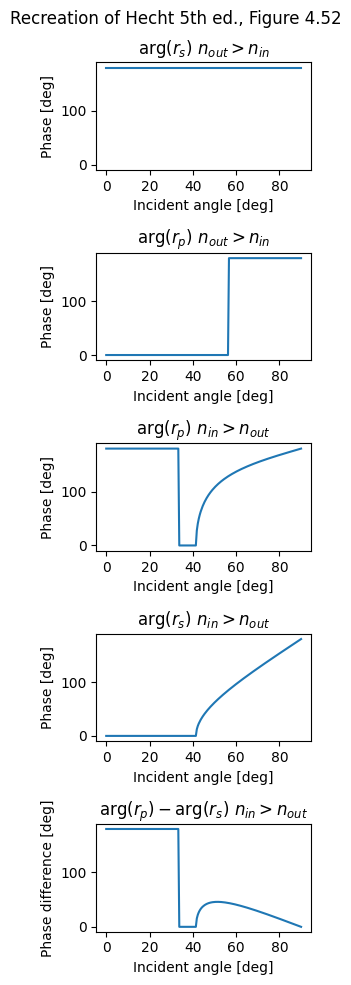

In [ ]:
# Recreate Figure 4.52 in E. Hecht's "Optics" (5th edition) textbook to check the equations above for correctness.
# Plot Fresnel amplitude coefficients

n_in = 1.0
n_out = 1.51

plt.figure(figsize = (3, 10))
plt.suptitle("Recreation of Hecht 5th ed., Figure 4.52")
plt.subplot(5, 1, 1)
plt.title(r"$\mathrm{arg}(r_s)\ n_{out}>n_{in}$")
plt.plot(np.rad2deg(thetas), np.rad2deg(np.angle(r_s(thetas, n_in, n_out))))
plt.ylim(-10, 190)
plt.xlabel("Incident angle [deg]")
plt.ylabel("Phase [deg]")

plt.subplot(5, 1, 2)
plt.title(r"$\mathrm{arg}(r_p)\ n_{out}>n_{in}$")
plt.plot(np.rad2deg(thetas), np.rad2deg(np.angle(r_p(thetas, n_in, n_out))))
plt.ylim(-10, 190)
plt.xlabel("Incident angle [deg]")
plt.ylabel("Phase [deg]")

n_in = 1.51
n_out = 1.0

plt.subplot(5, 1, 3)
plt.title(r"$\mathrm{arg}(r_p)\ n_{in}>n_{out}$")
plt.plot(np.rad2deg(thetas), np.rad2deg(np.angle(r_p(thetas, n_in, n_out))))
plt.ylim(-10, 190)
plt.xlabel("Incident angle [deg]")
plt.ylabel("Phase [deg]")

plt.subplot(5, 1, 4)
plt.title(r"$\mathrm{arg}(r_s)\ n_{in}>n_{out}$")
plt.plot(np.rad2deg(thetas), np.rad2deg(np.angle(r_s(thetas, n_in, n_out))))
plt.ylim(-10, 190)
plt.xlabel("Incident angle [deg]")
plt.ylabel("Phase [deg]")

# Phase difference between p and s polarization
dphis = np.angle(r_p(thetas, n_in, n_out)) - np.angle(r_s(thetas, n_in, n_out))
plt.subplot(5, 1, 5)
plt.title(r"$\mathrm{arg}(r_p) - \mathrm{arg}(r_s) \ n_{in}>n_{out}$")
plt.plot(np.rad2deg(thetas), np.rad2deg(dphis))
plt.xlabel("Incident angle [deg]")
plt.ylabel("Phase difference [deg]")

plt.tight_layout()

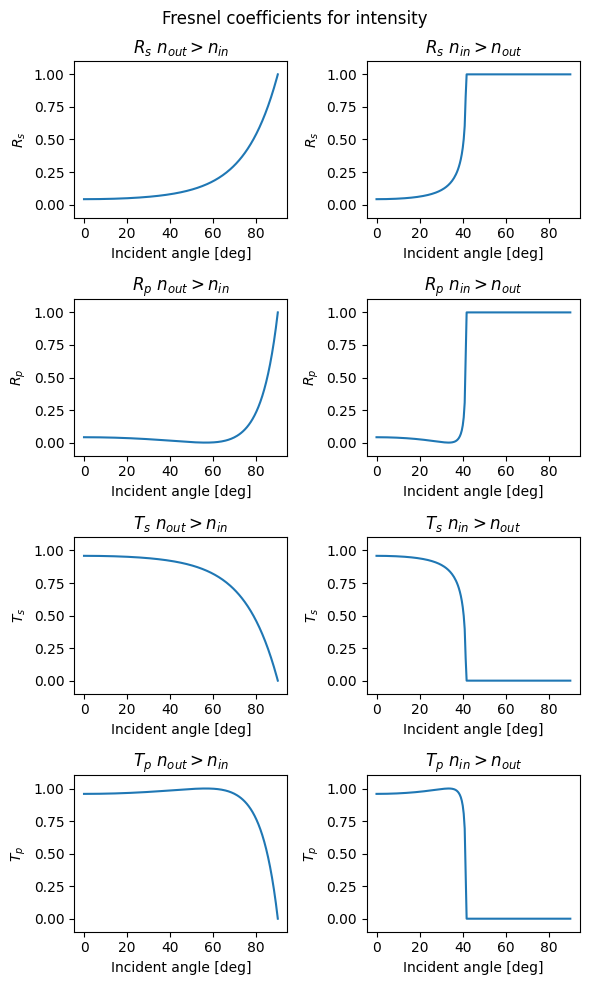

In [ ]:
# Plot Fresnel coefficients for intensity
plt.figure(figsize=(6, 10))
plt.suptitle("Fresnel coefficients for intensity")

n_in = 1.0
n_out = 1.51

plt.subplot(4, 2, 1)
plt.title(r"$R_s\ n_{out}>n_{in}$")
plt.plot(np.rad2deg(thetas), np.abs(r_s(thetas, n_in, n_out))**2)
plt.ylim(-0.1, 1.1)
plt.xlabel("Incident angle [deg]")
plt.ylabel(r"$R_s$")

plt.subplot(4, 2, 3)
plt.title(r"$R_p\ n_{out}>n_{in}$")
plt.plot(np.rad2deg(thetas), np.abs(r_p(thetas, n_in, n_out))**2)
plt.ylim(-0.1, 1.1)
plt.xlabel("Incident angle [deg]")
plt.ylabel(r"$R_p$")

plt.subplot(4, 2, 5)
plt.title(r"$T_s\ n_{out}>n_{in}$")
plt.plot(np.rad2deg(thetas), T_s(thetas, n_in, n_out))
plt.ylim(-0.1, 1.1)
plt.xlabel("Incident angle [deg]")
plt.ylabel(r"$T_s$")

plt.subplot(4, 2, 7)
plt.title(r"$T_p\ n_{out}>n_{in}$")
plt.plot(np.rad2deg(thetas), T_p(thetas, n_in, n_out))
plt.ylim(-0.1, 1.1)
plt.xlabel("Incident angle [deg]")
plt.ylabel(r"$T_p$")

n_in = 1.51
n_out = 1.0

plt.subplot(4, 2, 2)
plt.title(r"$R_s\ n_{in}>n_{out}$")
plt.plot(np.rad2deg(thetas), np.abs(r_s(thetas, n_in, n_out))**2)
plt.ylim(-0.1, 1.1)
plt.xlabel("Incident angle [deg]")
plt.ylabel(r"$R_s$")

plt.subplot(4, 2, 4)
plt.title(r"$R_p\ n_{in}>n_{out}$")
plt.plot(np.rad2deg(thetas), np.abs(r_p(thetas, n_in, n_out))**2)
plt.ylim(-0.1, 1.1)
plt.xlabel("Incident angle [deg]")
plt.ylabel(r"$R_p$")

plt.subplot(4, 2, 6)
plt.title(r"$T_s\ n_{in}>n_{out}$")
plt.plot(np.rad2deg(thetas), T_s(thetas, n_in, n_out))
plt.ylim(-0.1, 1.1)
plt.xlabel("Incident angle [deg]")
plt.ylabel(r"$T_s$")

plt.subplot(4, 2, 8)
plt.title(r"$T_p\ n_{in}>n_{out}$")
plt.plot(np.rad2deg(thetas), T_p(thetas, n_in, n_out))
plt.ylim(-0.1, 1.1)
plt.xlabel("Incident angle [deg]")
plt.ylabel(r"$T_p$")

plt.tight_layout()

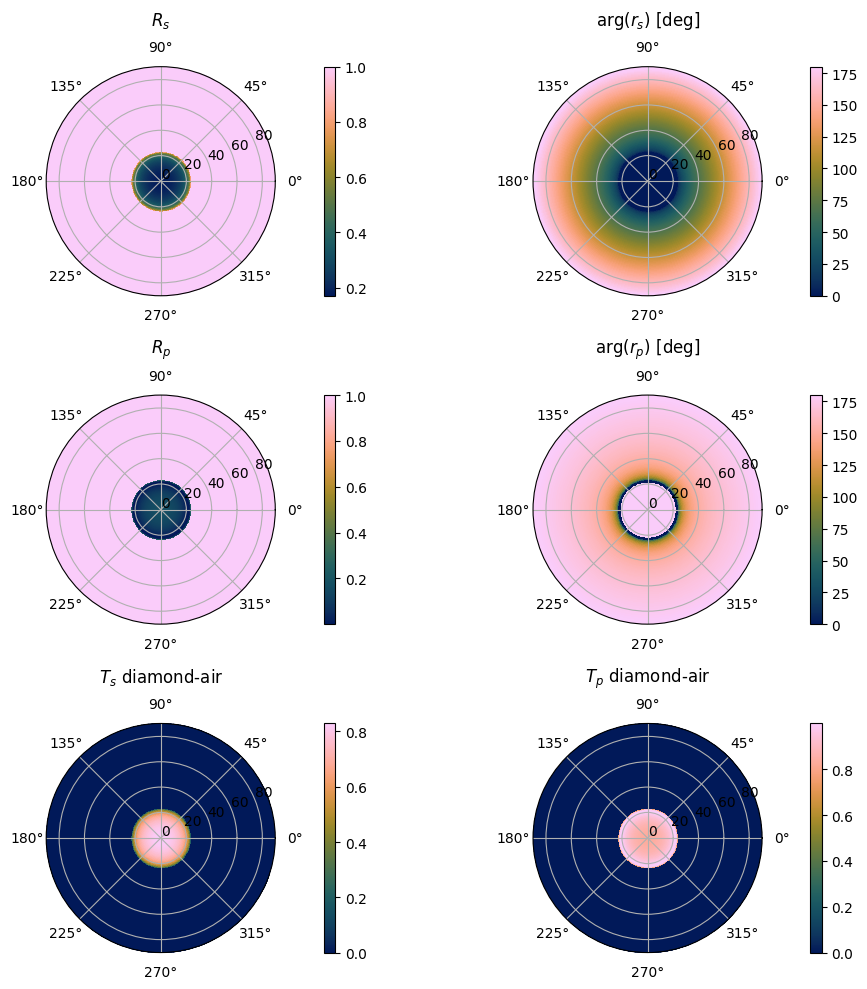

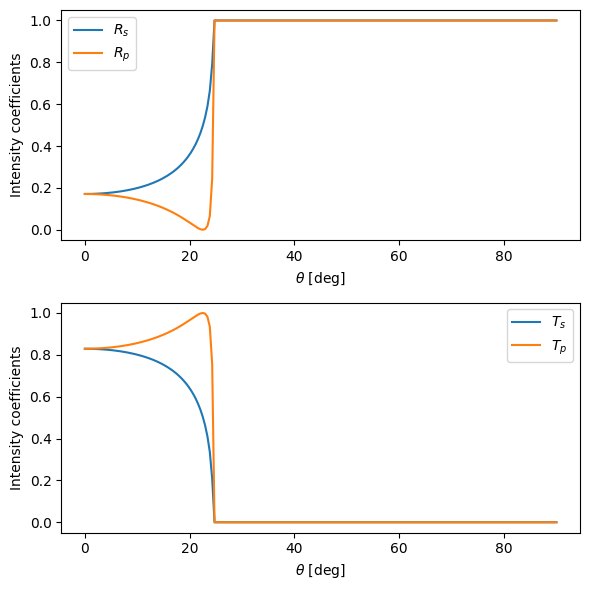

In [ ]:
# Calculate the Fresnel coefficients for the diamond-air and diamond-oil interface respectively
r_s_diamond_air = r_s(thetatheta, n_diamond, n_air)
r_p_diamond_air = r_p(thetatheta, n_diamond, n_air)

r_s_diamond_oil = r_s(thetatheta, n_diamond, n_oil)
r_p_diamond_oil = r_p(thetatheta, n_diamond, n_oil)

t_s_diamond_air = t_s(thetatheta, n_diamond, n_air)
t_p_diamond_air = t_p(thetatheta, n_diamond, n_air)

t_s_diamond_oil = t_s(thetatheta, n_diamond, n_oil)
t_p_diamond_oil = t_p(thetatheta, n_diamond, n_oil)

R_s_diamond_air = R_s(thetatheta, n_diamond, n_air)
R_p_diamond_air = R_p(thetatheta, n_diamond, n_air)

T_s_diamond_air = T_s(thetatheta, n_diamond, n_air)
T_p_diamond_air = T_p(thetatheta, n_diamond, n_air)

T_s_diamond_oil = T_s(thetatheta, n_diamond, n_oil)
T_p_diamond_oil = T_p(thetatheta, n_diamond, n_oil)

R_diamond_air = R_s_diamond_air + R_p_diamond_air
T_diamond_air = T_s_diamond_air + T_p_diamond_air

# Plot the Fresnel coefficients in polar plot
plt.figure(figsize=(10, 10))

plt.subplot(321, projection='polar')
plt.pcolormesh(phis,np.rad2deg(thetas),R_s_diamond_air, edgecolors='face')
plt.colorbar(pad=0.1)
plt.title("$R_s$", pad=30)

plt.subplot(322, projection='polar')
plt.pcolormesh(phis,np.rad2deg(thetas),np.rad2deg(np.angle(r_s_diamond_air)), edgecolors='face')
plt.colorbar(pad=0.1)
plt.title("arg($r_s$) [deg]", pad=30)

plt.subplot(323, projection='polar')
plt.pcolormesh(phis,np.rad2deg(thetas),R_p_diamond_air, edgecolors='face')
plt.colorbar(pad=0.1)
plt.title("$R_p$", pad=30)

plt.subplot(324, projection='polar')
plt.pcolormesh(phis,np.rad2deg(thetas),np.rad2deg(np.angle(r_p_diamond_air)), edgecolors='face')
plt.colorbar(pad=0.1)
plt.title("arg($r_p$) [deg]", pad=30)

plt.subplot(325, projection='polar')
plt.pcolormesh(phis,np.rad2deg(thetas),T_s_diamond_air, edgecolors='face')
plt.title(r"$T_s$ diamond-air", pad=30)
plt.colorbar(pad=0.1)

plt.subplot(326, projection='polar')
plt.pcolormesh(phis,np.rad2deg(thetas),T_p_diamond_air, edgecolors='face')
plt.title(r"$T_p$ diamond-air", pad=30)
plt.colorbar(pad=0.1)
plt.tight_layout()

# Plot the azimuthal average of the Fresnel coefficients for intensity
plt.figure(figsize = (6, 6))
plt.subplot(211)
plt.plot(np.rad2deg(thetas), np.mean(R_s_diamond_air, axis=1), label=r"$R_s$")
plt.plot(np.rad2deg(thetas), np.mean(R_p_diamond_air, axis=1), label=r"$R_p$")
plt.ylabel("Intensity coefficients")
plt.xlabel(r"$\theta$ [deg]")
plt.legend()

plt.subplot(212)
plt.plot(np.rad2deg(thetas), np.mean(T_s_diamond_air, axis=1), label=r"$T_s$")
plt.plot(np.rad2deg(thetas), np.mean(T_p_diamond_air, axis=1), label=r"$T_p$")
plt.ylabel("Intensity coefficients")
plt.xlabel(r"$\theta$ [deg]")
plt.legend()
plt.tight_layout()

## Compute dipole emission pattern at diamond-air interface for distances between dipole(s) and the interface
The pattern is generated by superimposing a dipole emission pattern with its mirror image reflected from the interface (see schematic below), taking into account the Fresnel coefficients and the phase delay induced by the shift of the image dipole.

Simulation schematic for colab script.svg

Text(0, 0.5, 'Dipole emission + mirror dipole\n (diamond-oil-interface filtered)')

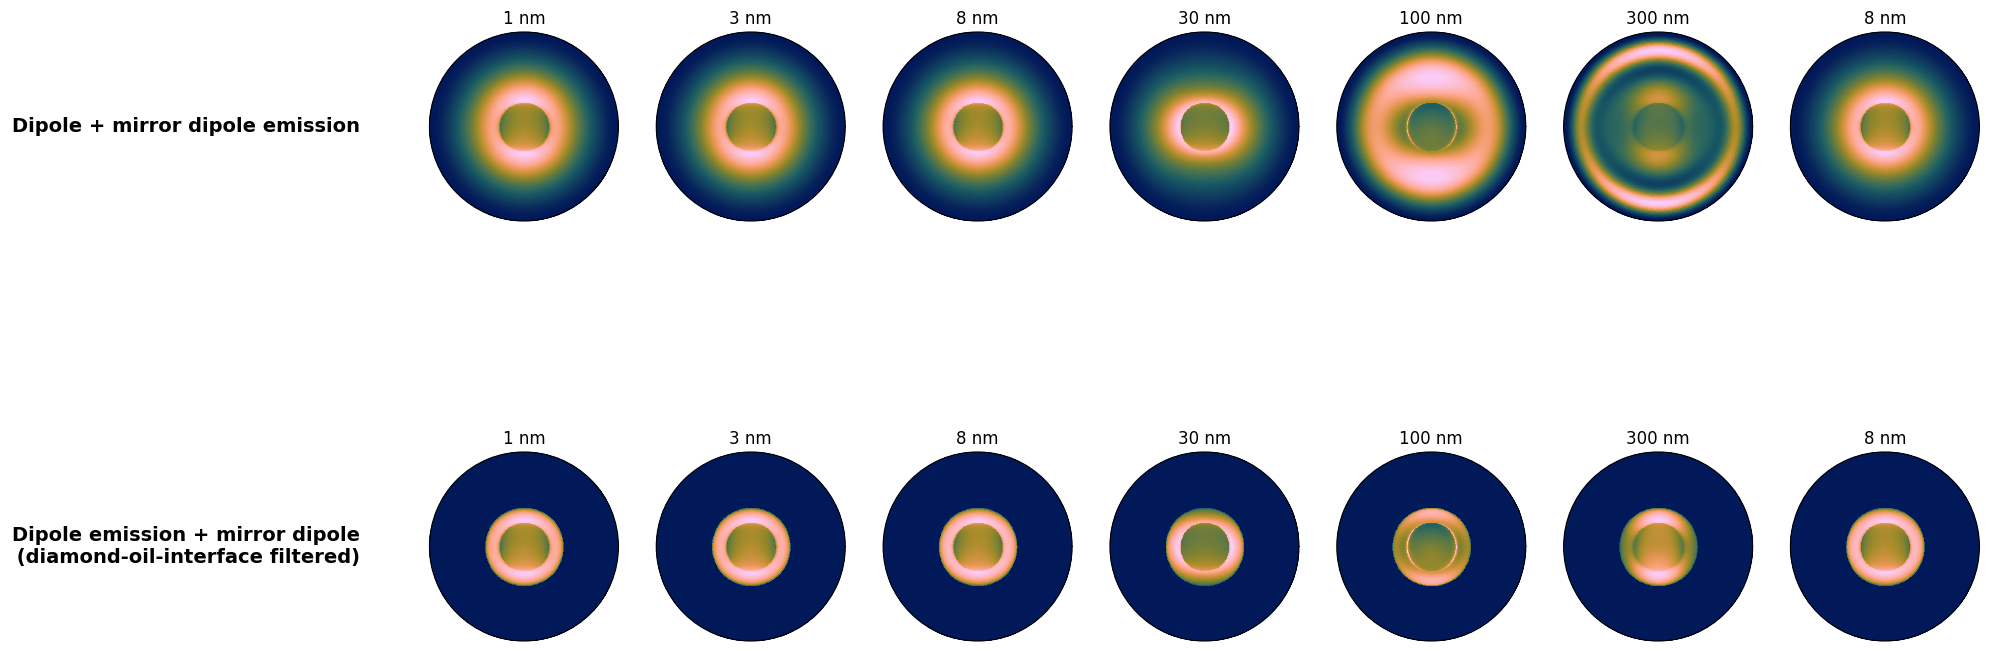

In [ ]:
ds = np.array((1e-9, 3e-9, 8e-9, 30e-9, 100e-9, 300e-9, 8e-9)) #distance of dipole from interface
# the last value of the array is set to 8 nm to calculate the emission pattern for the
# NV center implantation depth on this work
n_ds = len(ds)

plt.figure(figsize = (20, 10))

for di, d in enumerate(ds):
    Delta = 4*np.pi*n_diamond*d*np.cos(thetatheta)/lambda_0
    mirror_phase = np.exp(1j * Delta) #phase delay of mirror dipole

    total_intensity = np.zeros((N, N))
    total_intensity_filtered = np.zeros((N, N))

    for i in np.arange(n_dipoles):

        E_s = calc_E_s(thetatheta, phiphi, theta_dipole[i], phi_dipole[i])
        E_p_a = calc_E_p_a(thetatheta, phiphi, theta_dipole[i], phi_dipole[i])
        E_p_b = calc_E_p_b(thetatheta, phiphi, theta_dipole[i], phi_dipole[i])

        #compute total field emitted into lower half space, as a superposition of the
        #free dipole field (1) and its image dipole (r_s_diamond_air*mirror_phase)
        #(case ii in the table before eq. 10 in Lethiec et al.)
        E_s_tot = (1 + r_s_diamond_air*mirror_phase) * E_s
        E_p_tot = (1 + r_p_diamond_air*mirror_phase) * E_p_a + (1 - r_p_diamond_air*mirror_phase) * E_p_b

        total_intensity += np.absolute(E_s_tot)**2 + np.absolute(E_p_tot)**2
        total_intensity_filtered += T_s_diamond_oil*np.absolute(E_s_tot)**2 + T_p_diamond_oil*np.absolute(E_p_tot)**2

    # plot intensity on polar plot
    plt.subplot(2, n_ds, di+1, projection='polar')
    plt.pcolormesh(phis,np.rad2deg(thetas), total_intensity,edgecolors='face')
    plt.title(str(int(np.round(d*1e9)))+" nm")
    plt.xticks(())
    plt.yticks(())
    plt.subplot(2, n_ds, di+n_ds+1, projection='polar')
    plt.pcolormesh(phis,np.rad2deg(thetas), total_intensity_filtered,edgecolors='face')
    plt.title(str(int(np.round(d*1e9)))+" nm")
    plt.xticks(())
    plt.yticks(())

plt.subplot(2, n_ds, 1)
plt.ylabel("Dipole + mirror dipole emission", rotation=0, ha='right', va='center',
           labelpad=50, fontsize=14, fontweight='bold')
plt.subplot(2, n_ds, n_ds+1)
plt.ylabel("Dipole emission + mirror dipole\n (diamond-oil-interface filtered)",
           rotation=0, ha='right', va='center', labelpad=50, fontsize=14, fontweight='bold')

## Simulate emission into top half (diamond-air interface)

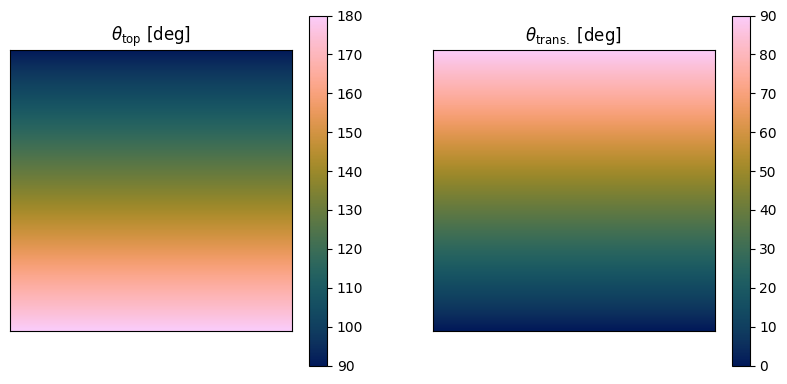

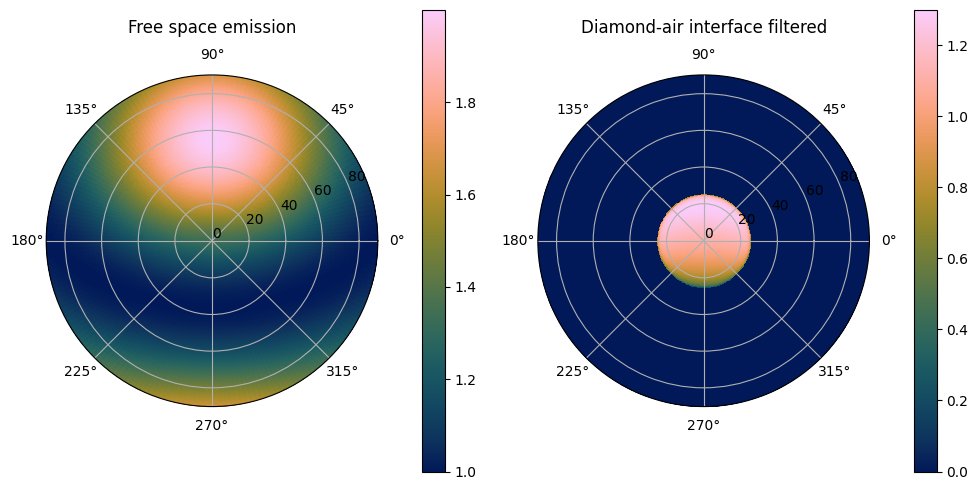

In [ ]:
# define new angular coordinates
phis_top, dphi = np.linspace(0,2*np.pi, N, retstep=True)
thetas_top, dtheta = np.linspace(np.pi/2, np.pi, N, retstep=True)
phiphi_top, thetatheta_top = np.meshgrid(phis_top, thetas_top)

# define angular coordinates used for calculating Fresnel transmission coefficients
# a dipole emission angle of 180° corresponds to an angle of incidence of 0° at the
# diamond-air interface
thetas_trans = np.pi - thetas_top
phis_trans = phis_top
phiphi_trans, thetatheta_trans = np.meshgrid(phis_trans, thetas_trans)

# plot the new coordinates
plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.imshow(np.rad2deg(thetatheta_top))
plt.colorbar()
plt.yticks([])
plt.xticks([])
plt.title(r"$\theta_{\mathrm{top}}$ [deg]")
plt.subplot(222)
plt.imshow(np.rad2deg(thetatheta_trans))
cbar = plt.colorbar()
plt.yticks([])
plt.xticks([])
plt.title(r"$\theta_{\mathrm{trans.}}$ [deg]")


# calculate Fresnel transmission coefficient for diamond-air interface
T_s_diamond_air = T_s(thetatheta_trans, n_diamond, n_air)
T_p_diamond_air = T_p(thetatheta_trans, n_diamond, n_air)

total_intensity_top = np.zeros((N, N))
total_intensity_top_filtered = np.zeros((N, N))

for i in np.arange(n_dipoles):

  # field on the air side is a single free dipole electric field,
  # no interference between reflected beams
  # compute free dipole field
  E_s = calc_E_s(thetatheta_top, phiphi_top, theta_dipole[i], phi_dipole[i])
  E_p_a = calc_E_p_a(thetatheta_top, phiphi_top, theta_dipole[i], phi_dipole[i])
  E_p_b = calc_E_p_b(thetatheta_top, phiphi_top, theta_dipole[i], phi_dipole[i])

  total_intensity_top += np.absolute(E_s)**2 + np.absolute(E_p_b + E_p_a)**2
  total_intensity_top_filtered += T_s_diamond_air * np.absolute(E_s)**2 + T_p_diamond_air * np.absolute(E_p_b + E_p_a)**2

# Plot the emitted intensity
plt.figure(figsize=(10, 5))
plt.subplot(121, projection='polar')
plt.pcolormesh(phis_trans,np.rad2deg(thetas_trans), total_intensity_top,edgecolors='face')
plt.colorbar(pad=0.1)
plt.title("Free space emission", pad=30)

plt.subplot(122, projection='polar')
plt.pcolormesh(phis_trans,np.rad2deg(thetas_trans), total_intensity_top_filtered, edgecolors='face')
plt.colorbar(pad=0.1)
plt.title("Diamond-air interface filtered", pad=30)
plt.tight_layout()

## Create antenna style plot of emission intensity

Text(0.5, 1.0, 'Angular emission density (norm.)')

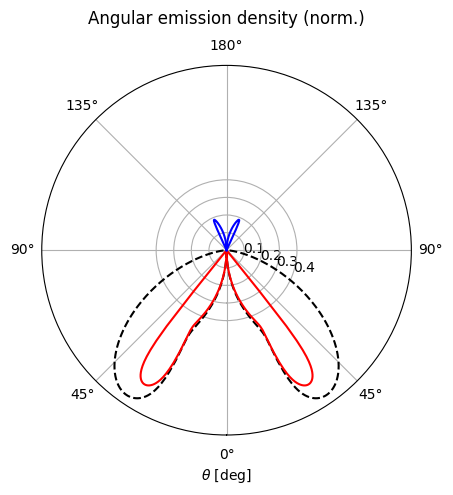

In [ ]:
# analyze emission into bottom (diamond) halfspace
# integrate emitted intensity over phi
phi_integrated_intensity = scipy.integrate.trapezoid(total_intensity * np.sin(thetatheta), phis, axis=1)
integrated_intensity = scipy.integrate.trapezoid(phi_integrated_intensity, thetas)

phi_integrated_intensity_filtered = scipy.integrate.trapezoid(total_intensity_filtered*np.sin(thetatheta), phis, axis=1)
integrated_intensity_filtered = scipy.integrate.trapezoid(phi_integrated_intensity_filtered, thetas)

# analyze emission into top (air) halfspace
# integrate emitted intensity over phi
phi_integrated_intensity_top = scipy.integrate.trapezoid(total_intensity_top*np.sin(thetatheta_trans), phis, axis=1)
integrated_intensity_top = scipy.integrate.trapezoid(phi_integrated_intensity_top, thetas)

phi_integrated_intensity_top_filtered = scipy.integrate.trapezoid(
    total_intensity_top_filtered*np.sin(thetatheta_trans), phis, axis=1)
integrated_intensity_top_filtered = scipy.integrate.trapezoid(phi_integrated_intensity_top_filtered, thetas)

fig, ax = plt.subplots(1, 1, subplot_kw={'projection': 'polar'})
xticks = np.deg2rad(np.array([0, 45, 90, 135, 180, 225, 270, 315]))
xticklabels = ["0°", "45°", "90°", "135°", "180°", "135°", "90°", "45°"]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_rlabel_position(70)
ax.set_yticks([0.1,0.2,0.3,0.4])
ax.set_rmax(0.25)
ax.set_theta_zero_location("S")

# normalize intensity
max_intensity = np.max(phi_integrated_intensity)

ax.plot(thetas, phi_integrated_intensity / max_intensity, linestyle="dashed", color="black")
ax.plot(-thetas, phi_integrated_intensity / max_intensity, linestyle="dashed", color="black")
ax.plot(thetas, phi_integrated_intensity_filtered / max_intensity, color="red")
ax.plot(-thetas, phi_integrated_intensity_filtered / max_intensity, color="red")
ax.plot(thetas_top, phi_integrated_intensity_top_filtered / max_intensity, color="blue")
ax.plot(-thetas_top, phi_integrated_intensity_top_filtered / max_intensity, color="blue")

ax.set_xlabel(r"$\theta$ [deg]")
ax.set_title(r"Angular emission density (norm.)", pad=30)

## Compute collection efficiency for various different immersion mediums and geometries

Text(0, 0.5, 'Collection efficiency')

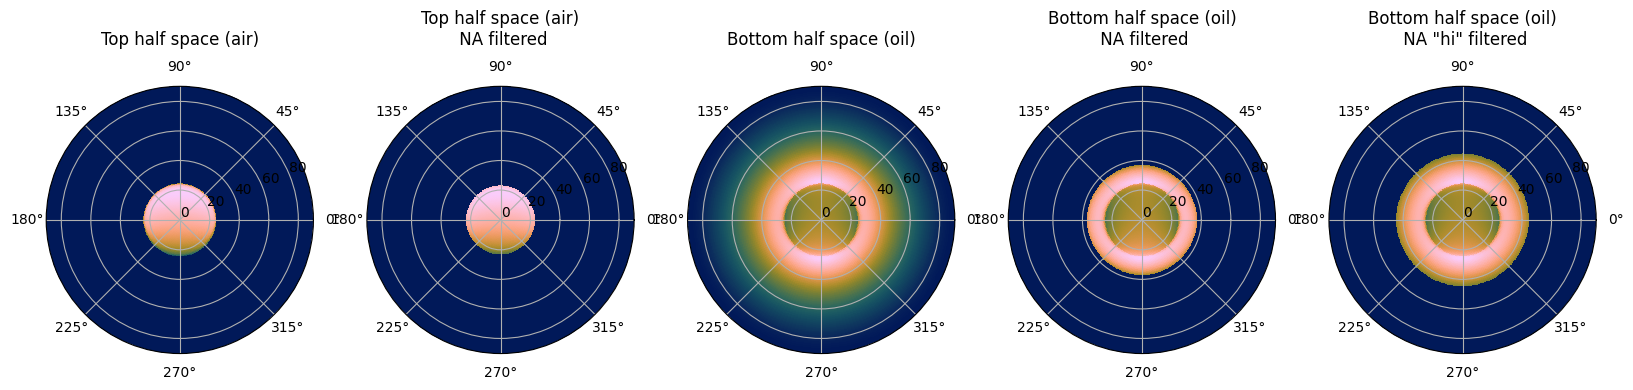

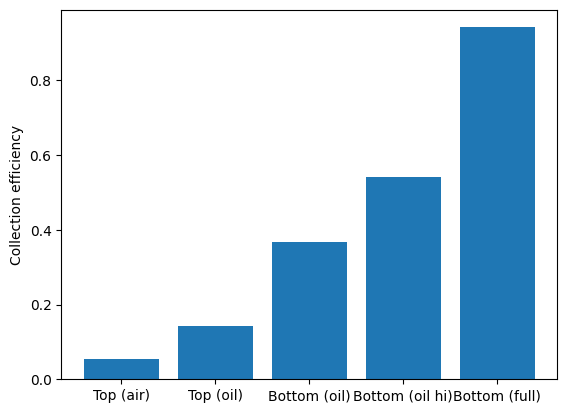

In [ ]:
# Compute collection efficiency for various different immersion mediums and geometries
def refract1D(theta_in, n_in, n_out):
    thetaout = np.arcsin(n_in/n_out * np.sin(theta_in))
    return thetaout

NA_air = 0.95
n_oil_hi = 1.78
n_oil = 1.51
# use realistic NA's that have approximately the same ratio "NA/n" as the 0.95 air objective
NA_oil = 1.45
NA_oil_hi = 1.7

d = 8e-9 # distance between dipoles and diamond-air interface

# Collection from the top side (air or oil immersion)
phis_top, dphi = np.linspace(0, 2*np.pi, N, retstep=True)
thetas_top, dtheta = np.linspace(np.pi, np.pi/2, N, retstep=True)
phiphi_top, thetatheta_top = np.meshgrid(phis_top, thetas_top)

thetas_trans = np.pi - thetas_top
phis_trans = phis_top
phiphi_trans, thetatheta_trans = np.meshgrid(phis_trans, thetas_trans)
T_s_diamond_air = T_s(thetatheta_trans, n_diamond, n_air)
T_p_diamond_air = T_p(thetatheta_trans, n_diamond, n_air)
T_s_diamond_oil = T_s(thetatheta_trans, n_diamond, n_oil)
T_p_diamond_oil = T_p(thetatheta_trans, n_diamond, n_oil)

thetaNA_air = np.arcsin(NA_air/n_air)
thetaNA_oil = np.arcsin(NA_oil/n_oil)
thetaNA_air = refract1D(thetaNA_air, n_air, n_diamond)
thetaNA_oil = refract1D(thetaNA_oil, n_oil, n_diamond)
NA_filter_air = (thetatheta <= thetaNA_air).astype(float) #filter to simulate cutoff by limited NA of objective
NA_filter_oil = (thetatheta <= thetaNA_oil).astype(float)

total_intensity_top_air_filtered = np.zeros((N, N)) #total intensity emitted into the air halfspace
total_intensity_top_air_filtered_NA = np.zeros((N, N))

total_intensity_top_oil_filtered = np.zeros((N, N)) #total intensity emitted into the oil halfspace
total_intensity_top_oil_filtered_NA = np.zeros((N, N))

for i in np.arange(n_dipoles):

    E_s = calc_E_s(thetatheta_top, phiphi_top, theta_dipole[i], phi_dipole[i])
    E_p_a = calc_E_p_a(thetatheta_top, phiphi_top, theta_dipole[i], phi_dipole[i])
    E_p_b = calc_E_p_b(thetatheta_top, phiphi_top, theta_dipole[i], phi_dipole[i])

    total_intensity_top_air_filtered += T_s_diamond_air*np.absolute(E_s)**2 + T_p_diamond_air*np.absolute(E_p_b + E_p_a)**2
    total_intensity_top_air_filtered_NA += T_s_diamond_air*np.absolute(E_s)**2 + T_p_diamond_air*np.absolute(E_p_b + E_p_a)**2

    total_intensity_top_oil_filtered += T_s_diamond_oil*np.absolute(E_s)**2 + T_p_diamond_oil*np.absolute(E_p_b + E_p_a)**2
    total_intensity_top_oil_filtered_NA += T_s_diamond_oil*np.absolute(E_s)**2 + T_p_diamond_oil*np.absolute(E_p_b + E_p_a)**2

total_intensity_top_air_filtered_NA *= NA_filter_air
total_intensity_top_oil_filtered_NA *= NA_filter_oil

# Emission into the lower halfspace (diamond side) with oil immersion collection
phis_bottom, dphi_bottom = np.linspace(0, 2*np.pi, N, retstep=True)
thetas_bottom, dtheta_bottom = np.linspace(0, np.pi/2, N, retstep=True)
phiphi_bottom, thetatheta_bottom = np.meshgrid(phis_bottom, thetas_bottom)

Delta = 4*np.pi*n_diamond*d*np.cos(thetatheta_bottom)/lambda_0
mirror_phase = np.exp(1j * Delta)  # phase delay of mirror dipole

total_intensity_bottom = np.zeros((N, N))
total_intensity_bottom_oil_top = np.zeros((N, N)) # bottom-side oil detection with oil on top
total_intensity_bottom_filtered_oil_NA = np.zeros((N, N))
total_intensity_bottom_filtered_oil_hi_NA = np.zeros((N, N))

T_s_diamond_oil = T_s(thetatheta_bottom, n_diamond, n_oil)
T_p_diamond_oil = T_p(thetatheta_bottom, n_diamond, n_oil)

T_s_diamond_oil_hi = T_s(thetatheta_bottom, n_diamond, n_oil_hi)
T_p_diamond_oil_hi = T_p(thetatheta_bottom, n_diamond, n_oil_hi)

thetaNA_oil = np.arcsin(NA_oil/n_oil)
thetaNA_oil = refract1D(thetaNA_oil, n_oil, n_diamond)
NA_filter_oil = (thetatheta_bottom <= thetaNA_oil).astype(float) #filter to simulate cutoff by limited NA of objective

thetaNA_oil_hi = np.arcsin(NA_oil_hi/n_oil_hi)
thetaNA_oil_hi = refract1D(thetaNA_oil_hi, n_oil_hi, n_diamond)
NA_filter_oil_hi = (thetatheta_bottom <= thetaNA_oil_hi).astype(float) #filter to simulate cutoff by limited NA of objective

for i in np.arange(n_dipoles):

    E_s = calc_E_s(thetatheta_bottom, phiphi_bottom, theta_dipole[i], phi_dipole[i])
    E_p_a = calc_E_p_a(thetatheta_bottom, phiphi_bottom, theta_dipole[i], phi_dipole[i])
    E_p_b = calc_E_p_b(thetatheta_bottom, phiphi_bottom, theta_dipole[i], phi_dipole[i])

    E_s_tot = (1 + r_s_diamond_air*mirror_phase)*E_s
    E_p_tot = (1 + r_p_diamond_air*mirror_phase)*E_p_a + (1 - r_p_diamond_air*mirror_phase)*E_p_b

    E_s_oil_tot = (1 + r_s_diamond_oil*mirror_phase)*E_s
    E_p_oil_tot = (1 + r_p_diamond_oil*mirror_phase)*E_p_a + (1 - r_p_diamond_oil*mirror_phase)*E_p_b

    total_intensity_bottom += np.absolute(E_s_tot)**2 + np.absolute(E_p_tot)**2
    total_intensity_bottom_oil_top += np.absolute(E_s_oil_tot)**2 + np.absolute(E_p_oil_tot)**2
    total_intensity_bottom_filtered_oil_NA += T_s_diamond_oil*np.absolute(E_s_tot)**2 + T_p_diamond_oil*np.absolute(E_p_tot)**2
    total_intensity_bottom_filtered_oil_hi_NA += T_s_diamond_oil_hi*np.absolute(E_s_tot)**2 + T_p_diamond_oil_hi*np.absolute(E_p_tot)**2


total_intensity_bottom_filtered_oil_NA *= NA_filter_oil
total_intensity_bottom_filtered_oil_hi_NA *= NA_filter_oil_hi

plt.figure(figsize=(20, 20))
plt.subplot(151, projection='polar')
plt.pcolormesh(phis_top, np.rad2deg(thetas_trans), total_intensity_top_air_filtered)
plt.title("Top half space (air)", pad=30)
plt.subplot(152, projection='polar')
plt.pcolormesh(phis_top, np.rad2deg(thetas_trans), total_intensity_top_air_filtered_NA)
plt.title("Top half space (air)\n NA filtered", pad=30)
plt.subplot(153, projection='polar')
plt.pcolormesh(phis_bottom, np.rad2deg(thetas_bottom), total_intensity_bottom)
plt.title("Bottom half space (oil)", pad=30)
plt.subplot(154, projection='polar')
plt.pcolormesh(phis_bottom, np.rad2deg(thetas_bottom), total_intensity_bottom_filtered_oil_NA)
plt.title("Bottom half space (oil)\n NA filtered", pad=30)
plt.subplot(155, projection='polar')
plt.pcolormesh(phis_bottom, np.rad2deg(thetas_bottom), total_intensity_bottom_filtered_oil_hi_NA)
plt.title("Bottom half space (oil)\n NA \"hi\" filtered", pad=30)


def integrate_halfspace(intensity, phis, thetas):
  # Perform double integration over phi and theta
  result = scipy.integrate.trapezoid(intensity, phis, axis=1)
  result = scipy.integrate.trapezoid(result*np.sin(thetas), thetas)
  return result

total_intensity_air_top = (integrate_halfspace(total_intensity_top_air_filtered, phis_trans, thetas_trans) +
               integrate_halfspace(total_intensity_bottom, phis_bottom, thetas_bottom))
total_intensity_oil_top = (integrate_halfspace(total_intensity_top_oil_filtered, phis_trans, thetas_trans) +
               integrate_halfspace(total_intensity_bottom_oil_top, phis_bottom, thetas_bottom))

collection_efficiency_top_air = integrate_halfspace(total_intensity_top_air_filtered_NA, phis_trans, thetas_trans)/total_intensity_air_top
collection_efficiency_top_oil = integrate_halfspace(total_intensity_top_oil_filtered_NA, phis_trans, thetas_trans)/total_intensity_oil_top
collection_efficiency_oil = integrate_halfspace(total_intensity_bottom_filtered_oil_NA, phis_bottom, thetas_bottom)/total_intensity_air_top
collection_efficiency_oil_hi = integrate_halfspace(total_intensity_bottom_filtered_oil_hi_NA, phis_bottom, thetas_bottom)/total_intensity_air_top
collection_efficiency_full_bottom_halfspace = integrate_halfspace(total_intensity_bottom, phis_bottom, thetas_bottom)/total_intensity_air_top

plt.figure()
labels = ["Top (air)", "Top (oil)", "Bottom (oil)", "Bottom (oil hi)", "Bottom (full)"]
plt.bar(labels, [collection_efficiency_top_air, collection_efficiency_top_oil, collection_efficiency_oil, collection_efficiency_oil_hi, collection_efficiency_full_bottom_halfspace])
plt.ylabel("Collection efficiency")

1.45
[np.float64(0.05361002008261266), np.float64(0.14299047315162042), np.float64(0.28487339339904116), np.float64(0.3667407750911649), np.float64(0.5402695674936733), np.float64(0.9416782367072214)]


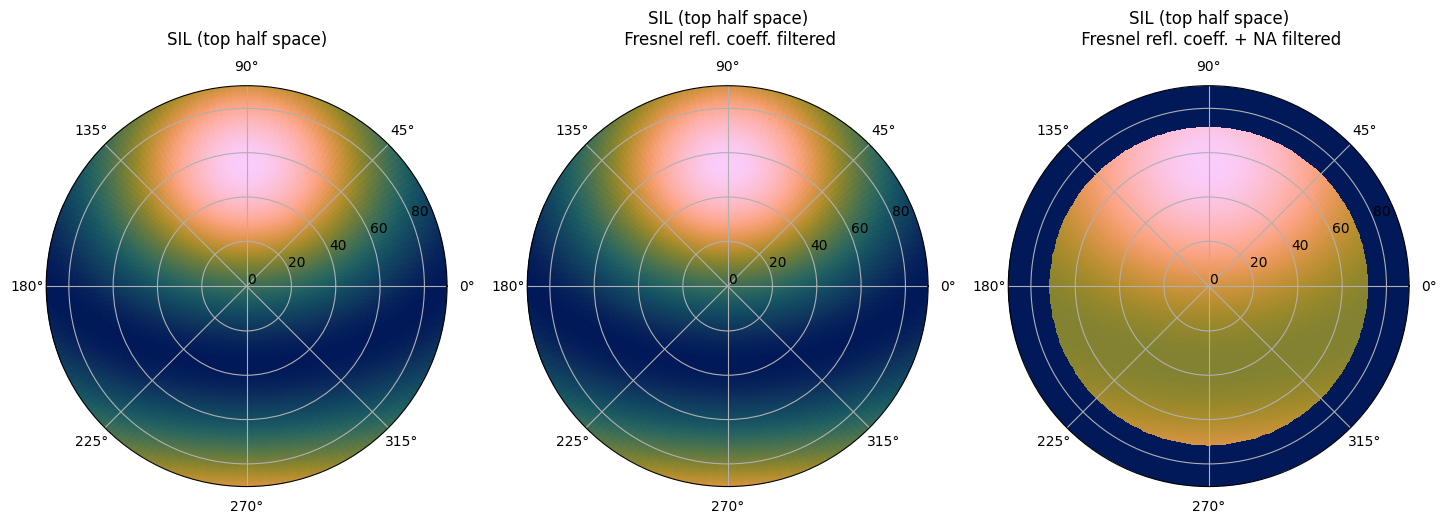

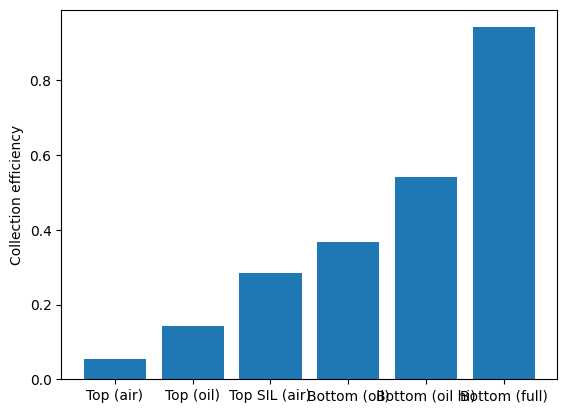

In [ ]:
# With SIL on the top (air immersion)
NA = NA_air
phis_top, dphi = np.linspace(0, 2*np.pi, N, retstep=True)
thetas_top, dtheta = np.linspace(np.pi, np.pi/2, N, retstep=True)
phiphi_top, thetatheta_top = np.meshgrid(phis_top, thetas_top)
thetas_trans = np.pi - thetas_top
phis_trans = phis_top
phiphi_trans, thetatheta_trans = np.meshgrid(phis_trans, thetas_trans)
# set incident angle to 0 for all emission angles (perfect SIL)
T_s_diamond_air = T_s(np.zeros((N, N)), n_diamond, n_air)
T_p_diamond_air = T_p(np.zeros((N, N)), n_diamond, n_air)

theta_NA = np.arcsin(NA/n_air)
NA_filter = (thetatheta_trans <= theta_NA)*1.0 #filter to simulate cutoff by limited NA of objective

total_intensity_top = np.zeros((N, N))
total_intensity_top_filtered = np.zeros((N, N))

for i in np.arange(n_dipoles):

    E_s = calc_E_s(thetatheta_top, phiphi_top, theta_dipole[i], phi_dipole[i])
    E_p_a = calc_E_p_a(thetatheta_top, phiphi_top, theta_dipole[i], phi_dipole[i])
    E_p_b = calc_E_p_b(thetatheta_top, phiphi_top, theta_dipole[i], phi_dipole[i])

    total_intensity_top += np.absolute(E_s)**2 + np.absolute(E_p_b + E_p_a)**2
    total_intensity_top_filtered += T_s_diamond_air*np.absolute(E_s)**2 + T_p_diamond_air*np.absolute(E_p_b + E_p_a)**2

total_intensity_top_filtered_NA = total_intensity_top_filtered*NA_filter

plt.figure(figsize=(30,30))
plt.subplot(151, projection='polar')
plt.pcolormesh(phis_top, np.rad2deg(thetas_trans), total_intensity_top)
plt.title("SIL (top half space)", pad=30)
plt.subplot(152, projection='polar')
plt.pcolormesh(phis_top, np.rad2deg(thetas_trans), total_intensity_top_filtered)
plt.title("SIL (top half space)\n Fresnel refl. coeff. filtered", pad=30)
plt.subplot(153, projection='polar')
plt.pcolormesh(phis_top, np.rad2deg(thetas_trans), total_intensity_top_filtered_NA)
plt.title("SIL (top half space)\n Fresnel refl. coeff. + NA filtered", pad=30)

total_intensity_SIL = 2*integrate_halfspace(total_intensity_top, phis_trans, thetas_trans)
collection_efficiency_SIL = integrate_halfspace(total_intensity_top_filtered_NA, phis_trans, thetas_trans)/total_intensity_SIL

plt.figure()
labels = ["Top (air)", "Top (oil)", "Top SIL (air)", "Bottom (oil)", "Bottom (oil hi)", "Bottom (full)"]
plt.bar(labels, [collection_efficiency_top_air, collection_efficiency_top_oil, collection_efficiency_SIL, collection_efficiency_oil, collection_efficiency_oil_hi, collection_efficiency_full_bottom_halfspace])
plt.ylabel("Collection efficiency")
print(mp.array([collection_efficiency_top_air, collection_efficiency_top_oil, collection_efficiency_SIL, collection_efficiency_oil, collection_efficiency_oil_hi, collection_efficiency_full_bottom_halfspace]))

Simulate collection efficiency for many different NV depths

---



In [ ]:
Nd = 401
ds = np.linspace(1e-9, 1e-6, Nd)

collection_efficiencies_oil = np.zeros(Nd)
collection_efficiencies_oil_hi = np.zeros(Nd)

r_s_diamond_air = r_s(thetatheta_bottom, n_diamond, n_air)
r_p_diamond_air = r_p(thetatheta_bottom, n_diamond, n_air)

T_s_diamond_oil = T_s(thetatheta_bottom, n_diamond, n_oil)
T_p_diamond_oil = T_p(thetatheta_bottom, n_diamond, n_oil)

for j, d in enumerate(ds):
  Delta = 4*np.pi*n_diamond*d*np.cos(thetatheta_bottom)/lambda_0
  mirror_phase = np.exp(1j * Delta)  # phase delay of mirror dipole

  total_intensity_bottom = np.zeros((N, N))
  total_intensity_bottom_filtered_oil_NA = np.zeros((N, N))

  for i in np.arange(n_dipoles):

      E_s = calc_E_s(thetatheta_bottom, phiphi_bottom, theta_dipole[i], phi_dipole[i])
      E_p_a = calc_E_p_a(thetatheta_bottom, phiphi_bottom, theta_dipole[i], phi_dipole[i])
      E_p_b = calc_E_p_b(thetatheta_bottom, phiphi_bottom, theta_dipole[i], phi_dipole[i])

      E_s_tot = (1 + r_s_diamond_air*mirror_phase)*E_s
      E_p_tot = (1 + r_p_diamond_air*mirror_phase)*E_p_a + (1 - r_p_diamond_air*mirror_phase)*E_p_b

      total_intensity_bottom += np.absolute(E_s_tot)**2 + np.absolute(E_p_tot)**2

      total_intensity_bottom_filtered_oil_NA += (T_s_diamond_oil*np.absolute(E_s_tot)**2 +
                                                    T_p_diamond_oil*np.absolute(E_p_tot)**2)

  total_intensity_air_top = (integrate_halfspace(total_intensity_top_air_filtered, phis_trans, thetas_trans) +
               integrate_halfspace(total_intensity_bottom, phis_bottom, thetas_bottom))

  total_intensity_bottom_filtered_oil_NA *= NA_filter_oil

  collection_efficiencies_oil[j] = integrate_halfspace(total_intensity_bottom_filtered_oil_NA, phis_bottom, thetas_bottom)/total_intensity_air_top


Find the first local extreme point of the collection efficiency vs NV depth graph and plot the angular emission for these points.

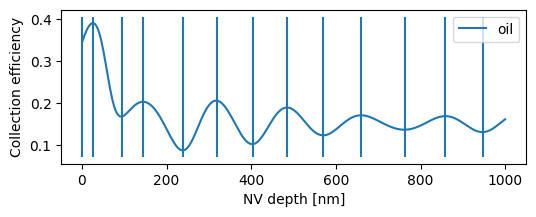

In [ ]:
plt.figure(figsize=(6,2))
plt.plot(ds*1e9, collection_efficiencies_oil, label="oil")
ylim = plt.ylim()
plt.xlabel("NV depth [nm]")
plt.ylabel("Collection efficiency")
plt.legend()

maxima = scipy.signal.find_peaks(collection_efficiencies_oil)[0]
maxima = np.append(0, maxima)
maxima = ds[maxima]

minima = scipy.signal.find_peaks(-collection_efficiencies_oil)[0]
minima = ds[minima]

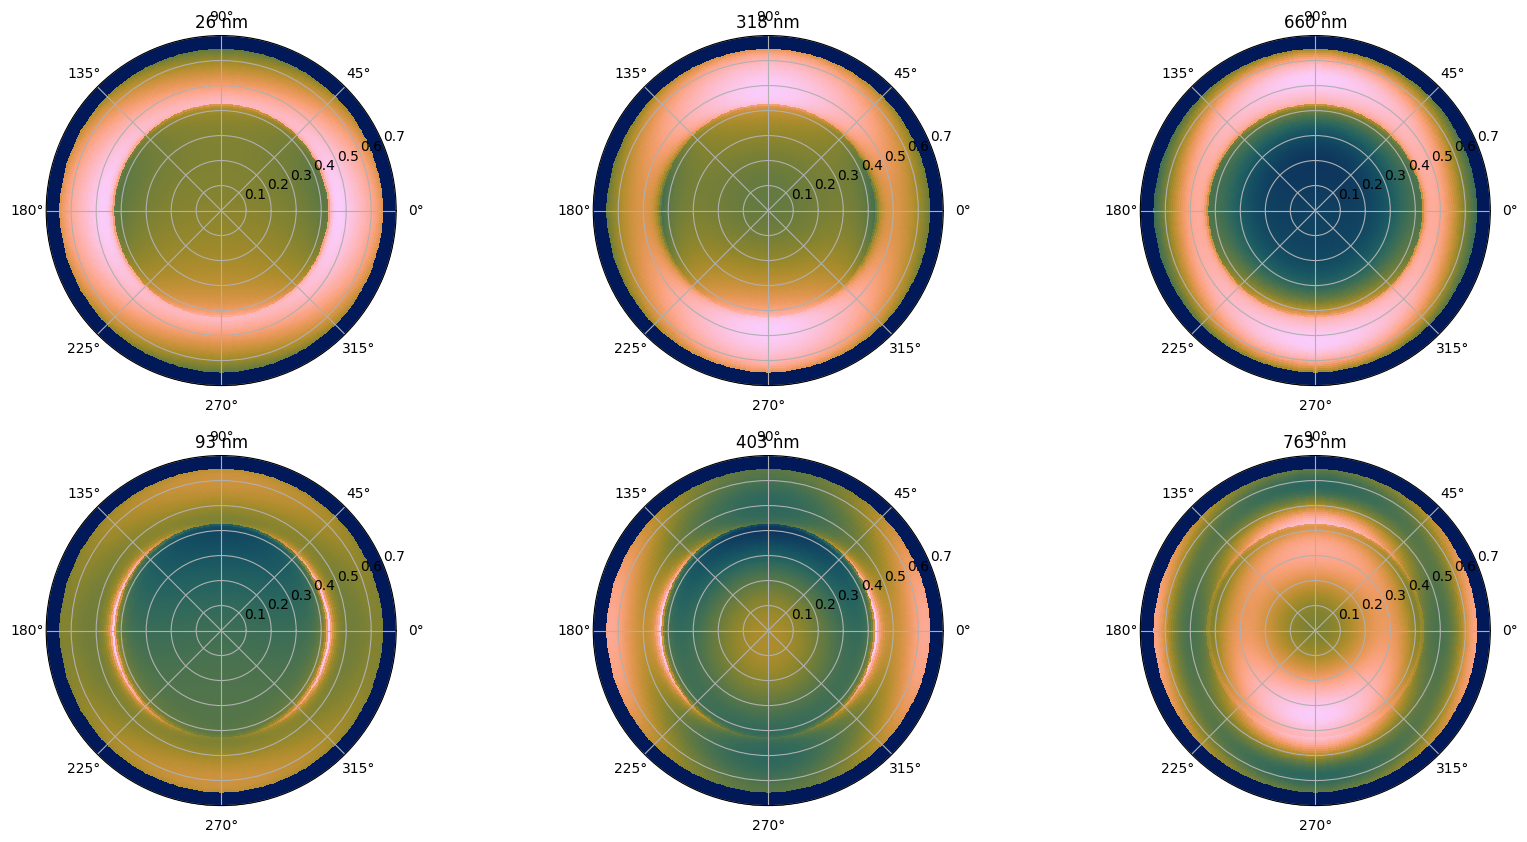

In [ ]:
ds_select = np.append(maxima[1::2], minima[::2])
Nd = ds_select.shape[0]

plt.figure(figsize=(20,10))
rows = 2

for j, d in enumerate(ds_select):
  Delta = 4*np.pi*n_diamond*d*np.cos(thetatheta_bottom)/lambda_0
  mirror_phase = np.exp(1j * Delta)  # phase delay of mirror dipole

  total_intensity_bottom_filtered_oil_NA = np.zeros((N, N))

  for i in np.arange(n_dipoles):

      E_s = calc_E_s(thetatheta_bottom, phiphi_bottom, theta_dipole[i], phi_dipole[i])
      E_p_a = calc_E_p_a(thetatheta_bottom, phiphi_bottom, theta_dipole[i], phi_dipole[i])
      E_p_b = calc_E_p_b(thetatheta_bottom, phiphi_bottom, theta_dipole[i], phi_dipole[i])

      E_s_tot = (1 + r_s_diamond_air*mirror_phase)*E_s
      E_p_tot = (1 + r_p_diamond_air*mirror_phase)*E_p_a + (1 - r_p_diamond_air*mirror_phase)*E_p_b

      total_intensity_bottom_filtered_oil_NA += (T_s_diamond_oil*np.absolute(E_s_tot)**2 +
                                                    T_p_diamond_oil*np.absolute(E_p_tot)**2)
      total_intensity_bottom_filtered_oil_hi_NA += (T_s_diamond_oil_hi*np.absolute(E_s_tot)**2 +
                                                    T_p_diamond_oil_hi*np.absolute(E_p_tot)**2)


  total_intensity_bottom_filtered_oil_NA *= NA_filter_oil
  total_intensity_bottom_filtered_oil_hi_NA *= NA_filter_oil_hi

  index = rows*100 + cols*10 + j +1
  plt.subplot(index, projection='polar')
  plt.pcolormesh(phis_bottom, thetas_bottom, total_intensity_bottom_filtered_oil_NA)
  plt.ylim([0,0.7])
  plt.title(str(int(np.round(d*1e9)))+" nm")